# SHAP value epxeriments

Experiment with the [SHAP package](https://github.com/shap/shap). For more details, see original paper [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874).

The examples in this notebook are taken from [here](https://shap.readthedocs.io/en/latest/overviews.html).

# An introduction to explainable AI with Shapley values
[source](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

In [1]:
import numpy as np
import sklearn
import shap

/Users/felixjust/anaconda3/envs/python_experiments/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 7

## Explaining a linear regression model

In [3]:
# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)
X100 = shap.utils.sample(X, 100, random_state=SEED)  # 100 instances for use as the background distribution

X100.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
11826,4.8051,21.0,5.857143,1.053391,1874.0,2.704185,39.00,-121.04
2206,4.2132,2.0,6.200306,1.123853,1730.0,2.645260,36.83,-119.88
5881,3.7941,37.0,4.771543,1.152305,1235.0,2.474950,34.16,-118.33
12678,4.3288,23.0,6.065217,0.934783,1407.0,3.058696,38.55,-121.38
11830,2.8603,17.0,6.427562,1.374558,736.0,2.600707,39.15,-120.87


In [4]:
# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

The most common way of understanding a linear model is to examine the coefficients learned for each feature. 

In [5]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


While coefficients are great for telling us what will happen when we change the value of an input feature, by themselves they are not a great way to measure the overall importance of a feature. This is because the value of each coefficient depends on the scale of the input features. If for example we were to measure the age of a home in minutes instead of years, then the coefficients for the HouseAge feature would become 0.0115 / (365∗24∗60) = 2.18e-8. Clearly the number of years since a house was built is not more important than the number of minutes, yet its coefficient value is much larger. This means that the magnitude of a coefficient is not necessarily a good measure of a feature’s importance in a linear model.

## A more complete picture using partial dependence plots

To understand a feature’s importance in a model, it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values. To visualize this for a linear model we can build a classical partial dependence plot and show the distribution of feature values as a histogram on the x-axis:

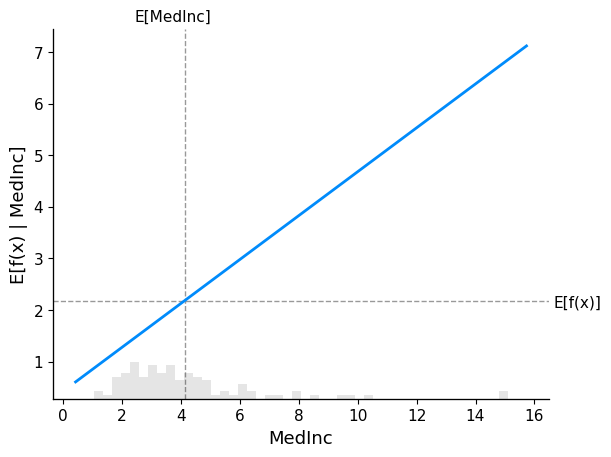

In [6]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [7]:
# verify

tmp = X100.copy(deep=True)
for c in tmp.columns:
    if c == "MedInc":
        pass
    else:
        tmp[c] = [tmp[c].mean() for i in range(len(X100))]

print(f"mean value of 'MedInc' {np.mean(X100.MedInc) :.2f}")
print(f"mean model prediction for 'MedInc' (setting all other features to their mean value): {model.predict(tmp).mean() :.2f}")

mean value of 'MedInc' 4.13
mean model prediction for 'MedInc' (setting all other features to their mean value): 2.18


## Reading SHAP values from partial dependence plots

SHAP values can be very complicated to compute (they are NP-hard in general), but linear models are so simple that we can read the SHAP values right off a partial dependence plot. When we are explaining a prediction $f(x)$, the SHAP value for a specific feature $i$ is just the difference between the expected model output and the partial dependence plot at the feature’s value $x_i$:

ExactExplainer explainer: 1001it [00:13, 26.56it/s]                             


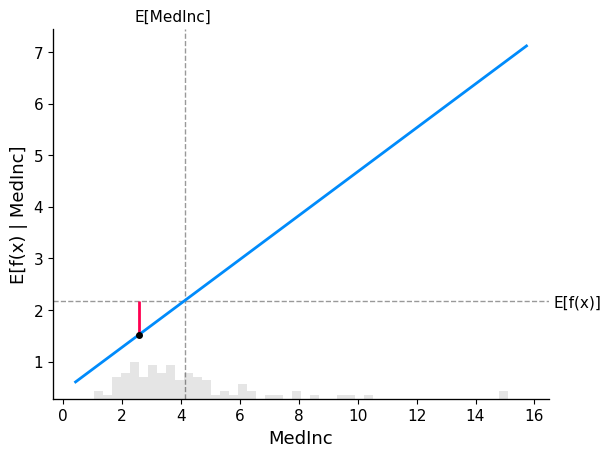

In [8]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

In [9]:
# print(shap_values.feature_names)
# print(len(shap_values.feature_names))
# print(shap_values.shape)

The close correspondence between the classic partial dependence plot and SHAP values means that if we plot the SHAP value for a specific feature across a whole dataset we will exactly trace out a mean centered version of the partial dependence plot for that feature:

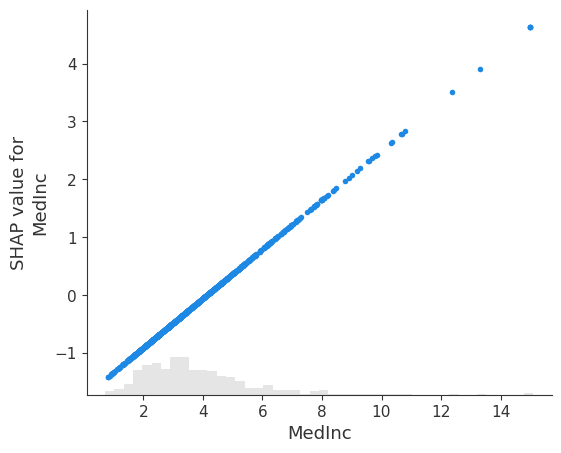

In [10]:
shap.plots.scatter(shap_values[:, "MedInc"])

## The additive nature of Shapley values

One of the fundamental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

The easiest way to see this is through a waterfall plot that starts at our background prior expectation for a home price $\mathrm{E}[f(x)]$
, and then adds features one at a time until we reach the current model output $f(x)$ :

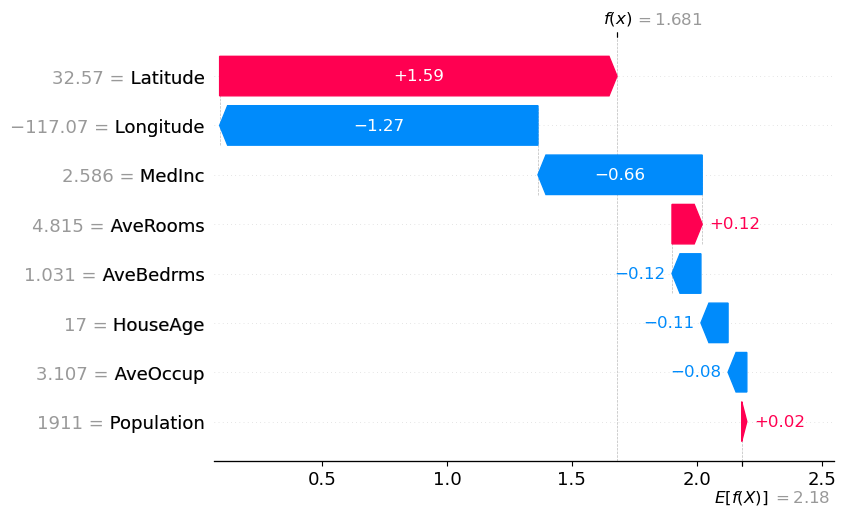

In [11]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [12]:
print(f"model prediction when all features are set to their mean value: {model.predict(X100.mean().values.reshape(1, -1))[0] :.3f}")
print(f"model prediction for x:                                         {model.predict(X)[sample_ind] :.3f}")

model prediction when all features are set to their mean value: 2.180
model prediction for x:                                         1.681


/Users/felixjust/anaconda3/envs/python_experiments/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In other words, we start with the model prediction of $x$ when all features are set to their mean value $\mathrm{E}[f(x)]$ which corresponds to *no players are present*. Then the features are added one at a time until we arrive at $f(x)$ which is the prediction of the model for $x$ using all features and correspons to the case where *all players are present*. 

## Explaining an additive regression model

The reason the partial dependence plots of linear models have such a close connection to SHAP values is because each feature in the model is handled independently of every other feature (the effects are just added together). We can keep this additive nature while relaxing the linear requirement of straight lines. This results in the well-known class of generalized additive models (GAMs). While there are many ways to train these types of models (like setting an XGBoost model to depth-1), we will use InterpretMLs explainable boosting machines that are specifically designed for this.

In [13]:
# fit a GAM model to the data
import interpret.glassbox

model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

ExplainableBoostingRegressor(interactions=0)

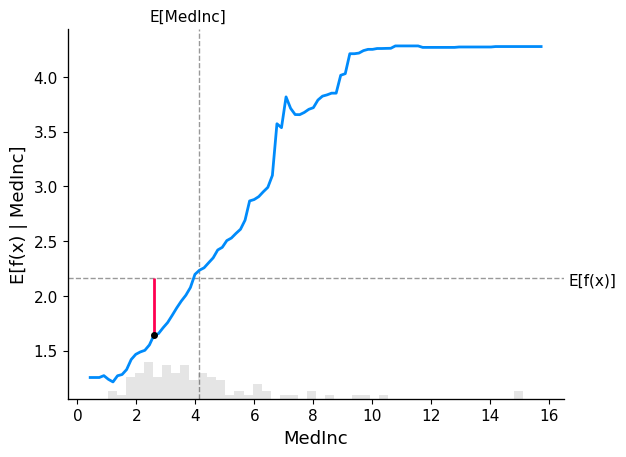

In [14]:
# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_ebm.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[sample_ind : sample_ind + 1, :],
)

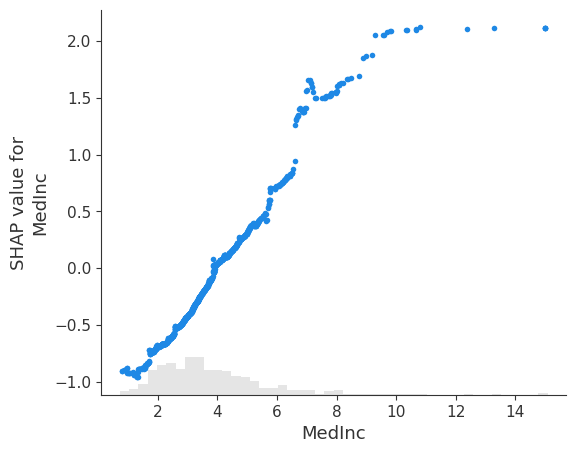

In [15]:
shap.plots.scatter(shap_values_ebm[:, "MedInc"])

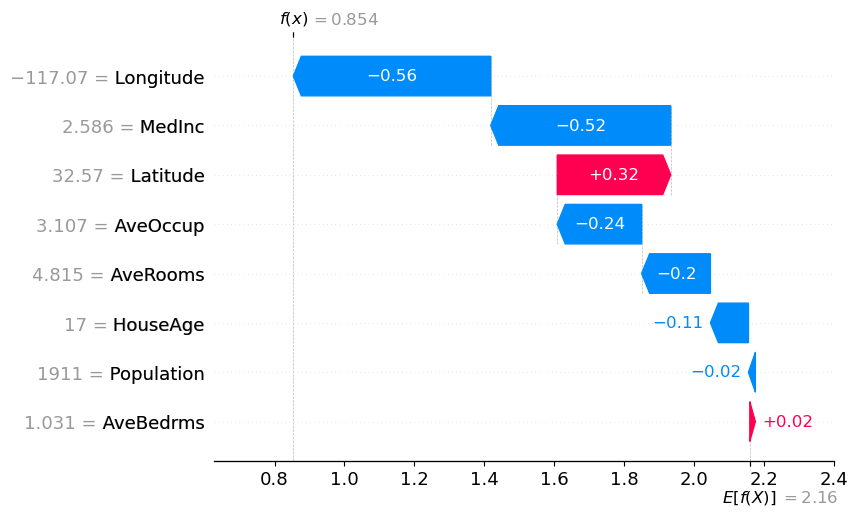

In [16]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind])

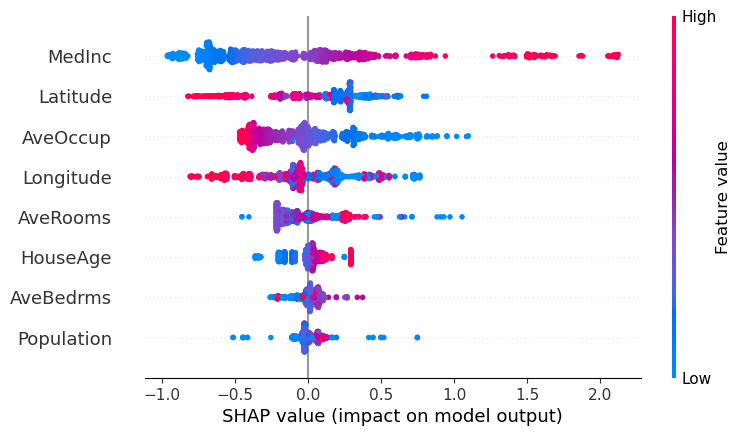

In [17]:
shap.plots.beeswarm(shap_values_ebm)

## Explaining a non-additive boosted tree model

In [18]:
# train XGBoost model
import xgboost

model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

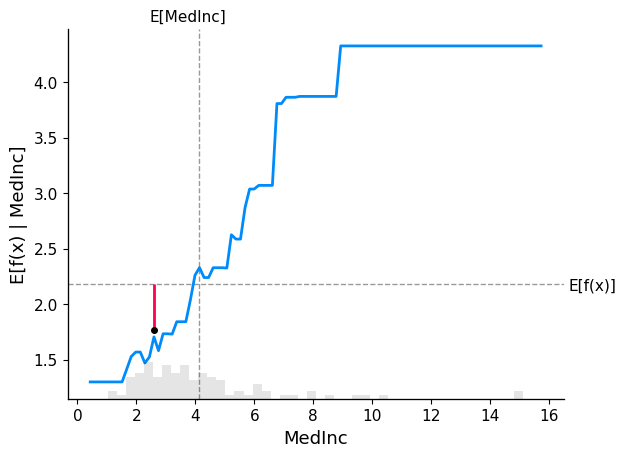

In [19]:
# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_xgb.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)

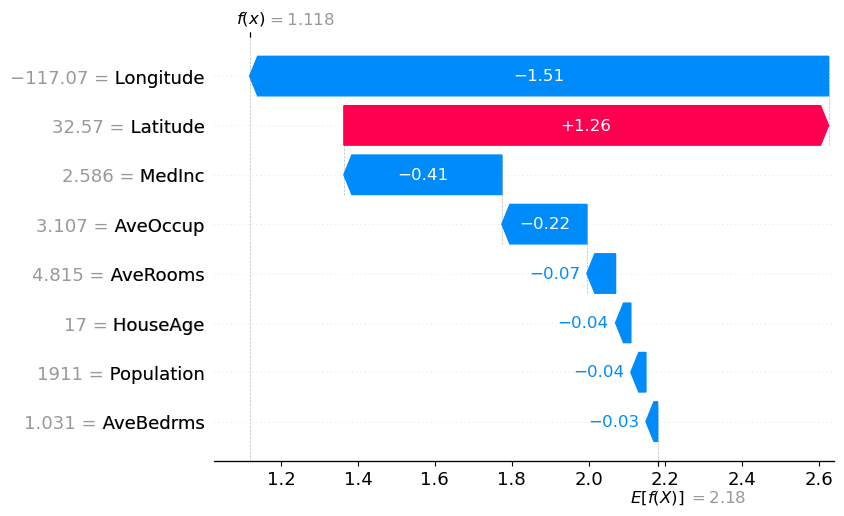

In [20]:
shap.plots.waterfall(shap_values_xgb[sample_ind])

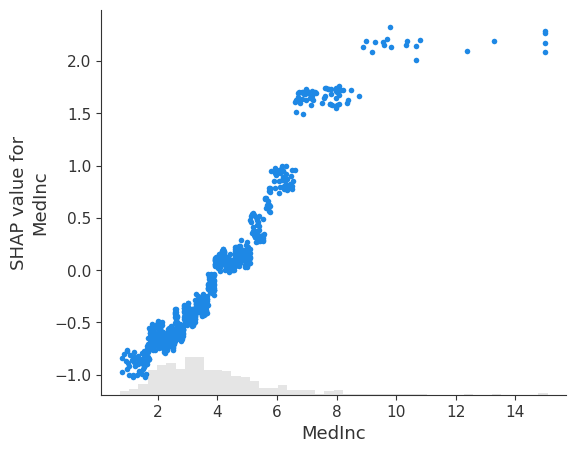

In [21]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"])

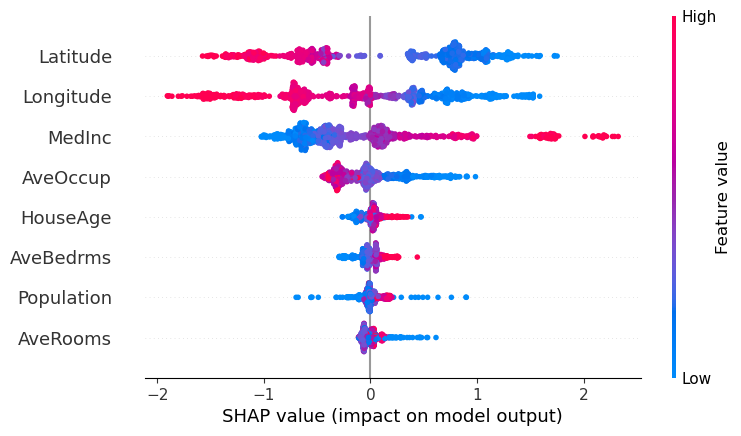

In [22]:
shap.plots.beeswarm(shap_values_xgb)

# Census income classification with XGBoost
[source](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html)

In [23]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

In [24]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

display(X_train.head())
y_train

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
12011,51.0,4,10.0,0,6,0,4,0,0.0,0.0,40.0,21
23599,51.0,1,14.0,6,12,1,4,1,0.0,0.0,50.0,8
23603,21.0,4,11.0,4,3,3,2,1,0.0,0.0,40.0,39
6163,25.0,4,10.0,4,12,3,4,1,0.0,0.0,24.0,39
14883,48.0,4,13.0,0,1,3,4,1,0.0,0.0,38.0,39


array([False,  True, False, ..., False,  True, False])

In [25]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

## Train model

In [26]:
%%time

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.54663
[100]	test-logloss:0.36398
[200]	test-logloss:0.31758
[300]	test-logloss:0.30065
[400]	test-logloss:0.29170
[500]	test-logloss:0.28655
[600]	test-logloss:0.28358
[700]	test-logloss:0.28174
[800]	test-logloss:0.28061
[900]	test-logloss:0.27988
[1000]	test-logloss:0.27939
[1100]	test-logloss:0.27906
[1177]	test-logloss:0.27888
CPU times: user 34.3 s, sys: 2.57 s, total: 36.8 s
Wall time: 5.42 s


## classical feature importance

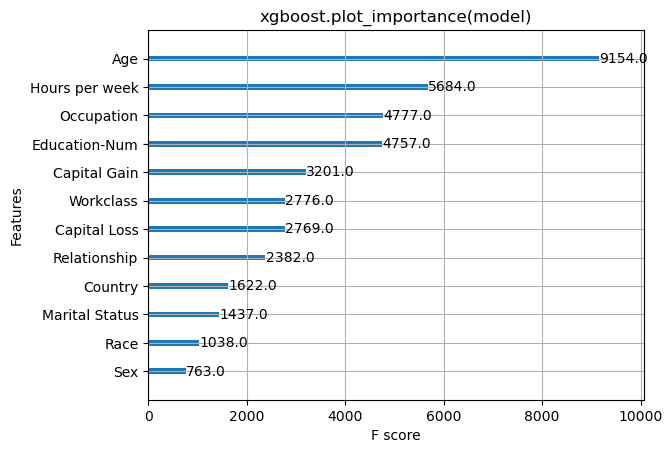

In [27]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

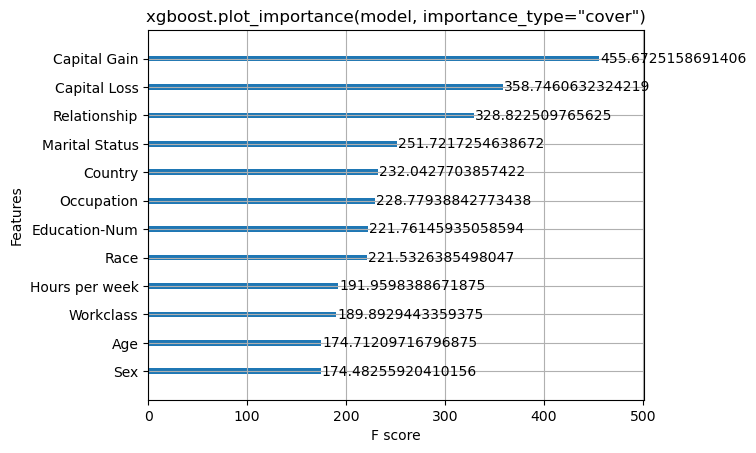

In [28]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

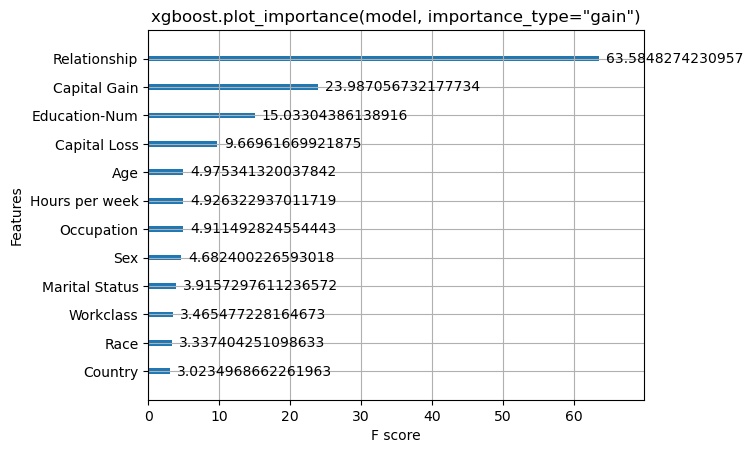

In [29]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## SHAP values

In [30]:
%%time

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

CPU times: user 14min 2s, sys: 3.04 s, total: 14min 5s
Wall time: 1min 56s


## explain a single prediction

Note that we use the “display values” data frame so we get nice strings instead of category codes.



In [31]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])

In [32]:
l = sum(shap_values[0, :]) + explainer.expected_value

def calc_prob(logit):
    prob = 1/(1+np.exp(- (logit) ))
    return prob
    
print(f"expected logit for no feature:      {explainer.expected_value :.3f}")
print(f"expected logit f(x):                {l :.3f} ")
print(f"convert logit f(x) to probability:  {calc_prob(l) :.3f}")
print(f"model prediction for x:             {model.predict(xgboost.DMatrix(X.iloc[0:1,:]))[0] :.3f}")

# display(X_display.iloc[0, :])

expected logit for no feature:      -1.144
expected logit f(x):                -4.055 
convert logit f(x) to probability:  0.017
model prediction for x:             0.017


## Visualize many predictions

To keep the browser happy we do not visualize all individuals.

In [33]:
num_points = 1_000

shap.force_plot(
    explainer.expected_value, shap_values[:num_points, :], X_display.iloc[:num_points, :]
)

## Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

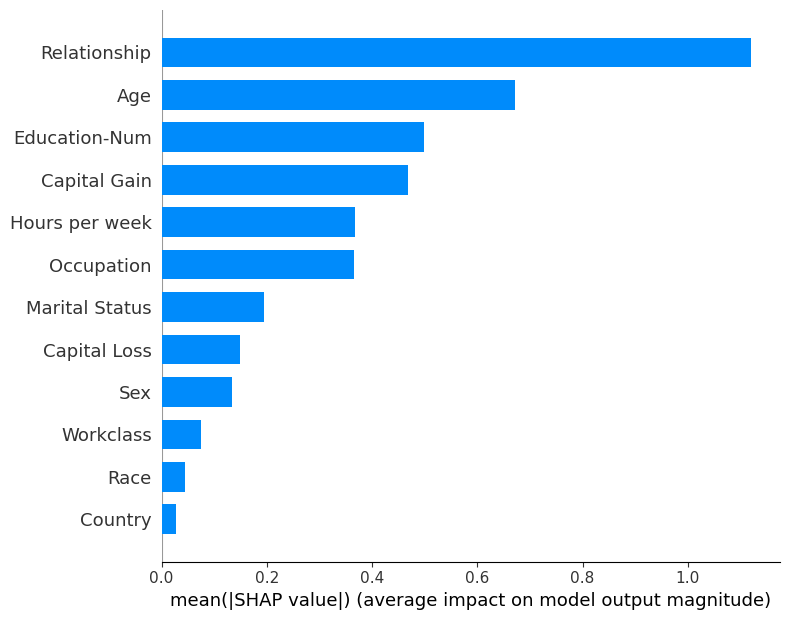

In [34]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

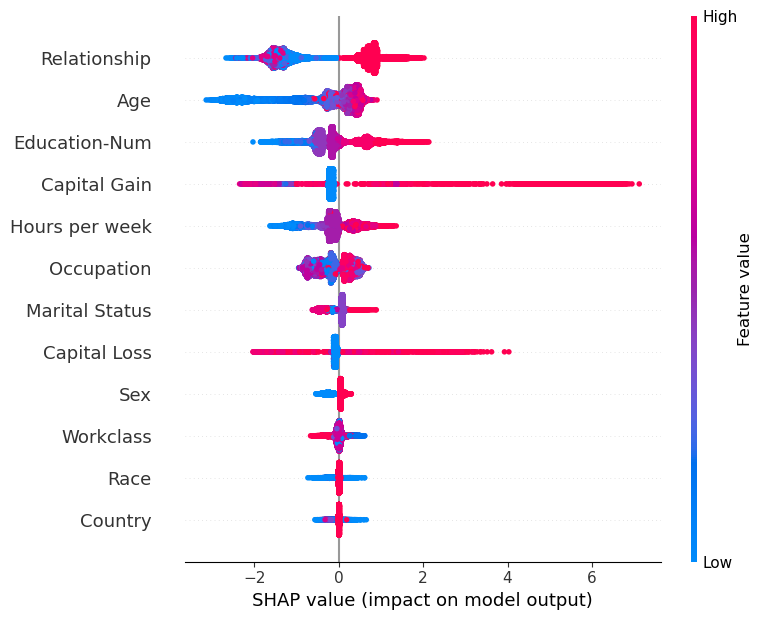

In [35]:
shap.summary_plot(shap_values, X)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

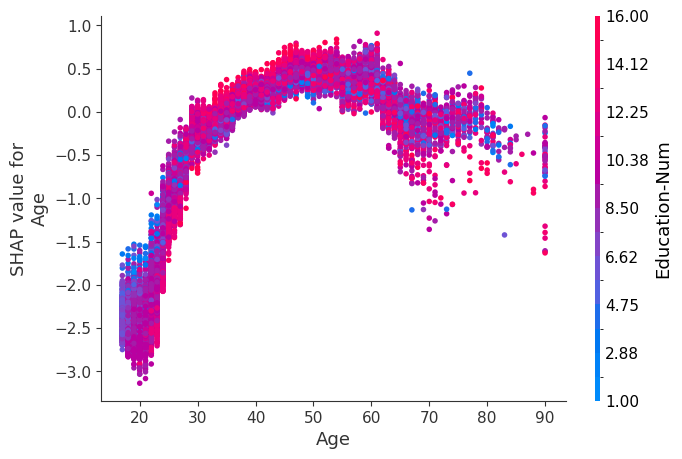

In [37]:
shap.dependence_plot("Age", shap_values, X, display_features=X_display, interaction_index="Education-Num")